# Solution Assignment 2: MNIST

This is the solution for the second assignment of the Implementing Artificial Neural Networks with TensorFlow course. Please find the according assignment sheet on studip.

## Imports
We are going to use `tensorflow` to implement the neural network, `numpy` for the preparation of our training data and `matplotlib` to plot the training process of the network and the change of weights over time. The `struct` library is required to read the header of the binary MNIST data files and `os` is required to join directory paths. Finally, we activate inline plotting by calling `%matplotlib notebook`.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import struct
import os

%matplotlib notebook

## The MNIST helper class
When an instance of this class is created, the training and test images and coresponding labels are read from the MNIST binary files from `directory`. Further, 10% of the training data is separated into a validation data-set.

The class provides three methods to iterate over the training, validation and test data respectively. If `batch_size` is set to a value `<= 0`, the method returns all data and labels at once.

In [5]:
class MNIST():
    def __init__(self, directory):
        self._directory = directory
        
        self._training_data = self._load_binaries("train-images.idx3-ubyte")
        self._training_labels = self._load_binaries("train-labels.idx1-ubyte")
        self._test_data = self._load_binaries("t10k-images.idx3-ubyte")
        self._test_labels = self._load_binaries("t10k-labels.idx1-ubyte")
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            elif "labels" in file_name and check == 2049:
                return np.fromfile(fd, dtype = 'uint8')
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n
    
        
    

## Creating a new MNIST instance
Since the MNIST class reads the MNIST data every time we create a new instance, we are going to create a single instance here and reuse it in the cells bellow.

This script assumes, that the MNIST data files are located in a subdirectory "data".

In [7]:
mnist = MNIST(os.getcwd())

## Investigating the data
Before we start to use the data we should always try to understand its structure and double check, that data and labels are assigned correctly. Therefore, we plot some samples and the respective labels.

<IPython.core.display.Javascript object>


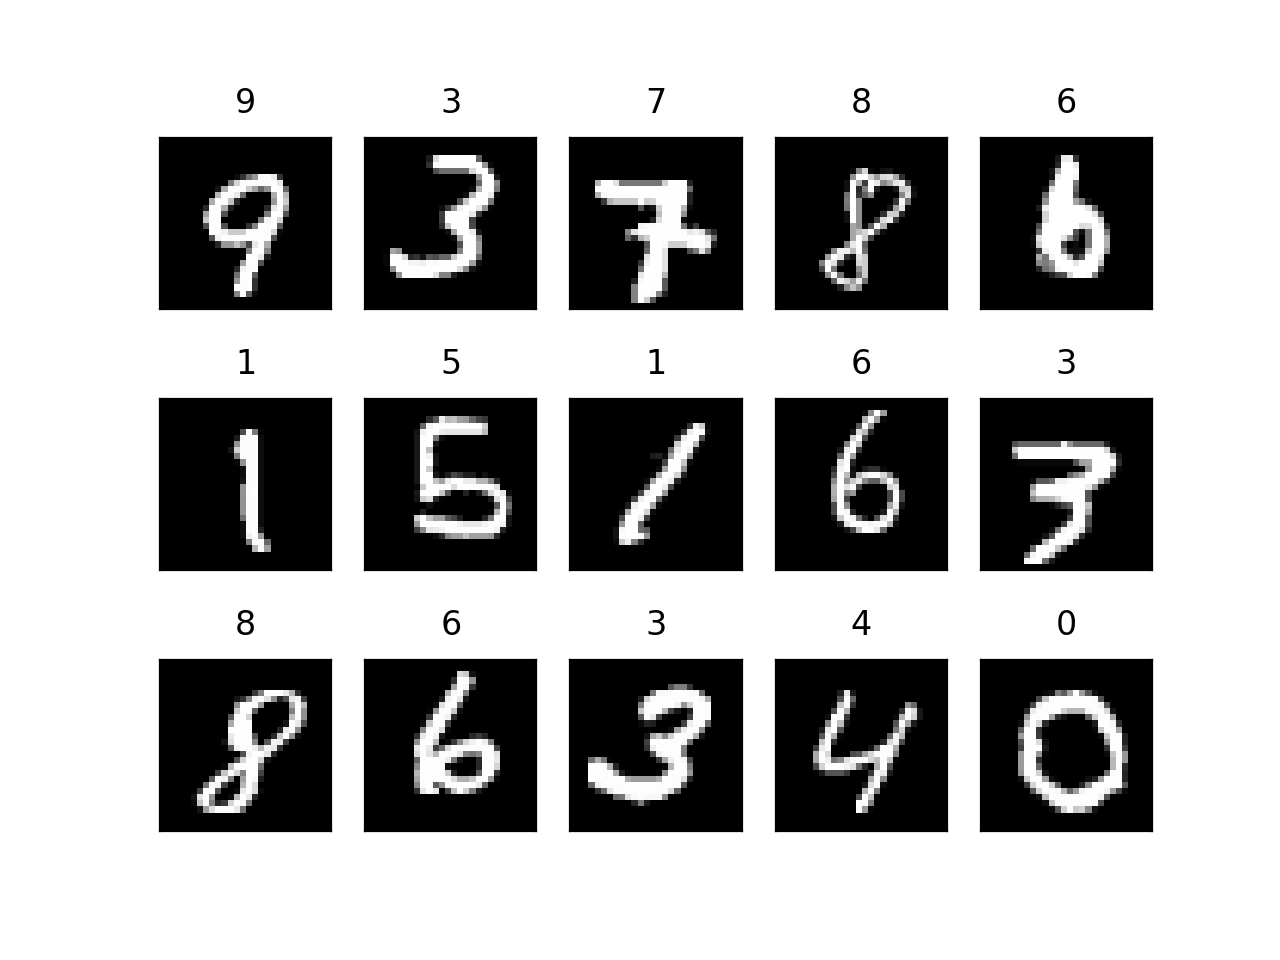

In [8]:
images, labels = next(mnist.get_training_batch(25))

fig, axs = plt.subplots(3, 5)
for i, ax in enumerate(np.reshape(axs, [-1])):
    ax.matshow(images[i], cmap = 'gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(labels[i])

## Construction phase
In the construction phase, we define the data flow graph with the help of TensorFlow's mathematical operations.

We define the data flow graph of a singly-layer fully connected feed-forward neural network. Each of our ten output neurons tries to learn the pattern for one of the 10 handwritten digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9).

![IMAGE MISSING: network-structure.png](network-structure.png)

We define __variables__ for our weights and biases, since those are the values that we want to keep and adjust between training steps. Further, we define a __placeholder__ for a vectorized batch of images of not yet defined size (`[None, 784]`) and anoter __placeholder__ for the list of the respective labels.

The term _logits_ refers to the raw output of the neurons without the application of an activation function.

In [9]:
x = tf.placeholder(tf.float32, [None, 784])
desired = tf.placeholder(tf.int64, [None])

weights = tf.Variable(tf.random_normal([784, 10], stddev = 0.000002))
biases = tf.Variable(tf.zeros([10]))

logits = tf.matmul(x, weights) + biases

Instructions for updating:
Colocations handled automatically by placer.


The activation function, in this case the softmax function, is going to be applied by the `sparse_softmax_cross_entropy_with_logits` function, which also calculates the cross entropy between the _logits_ and the desired output for us.

Since we are going to train with mini-batches, we will receive one cross entropy value for each sample in our mini-batch. In order to get a measure of the networks overall performance on the mini-batch, we calculate the mean of the different cross entropy values.

In [10]:
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = desired, logits = logits)
cross_entropy = tf.reduce_mean(cross_entropy)

Next, we are going to specify the gradient descent algorithm that we would like to use in order to optimize the variables of our network. In this case, we are going to use standard gradient descent with a learning rate of `1e-5`.

Further, we create a measure for the accuracy of our network by calculating the amount of correctly labeled samples.

In [11]:
learning_rate = 1e-5
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_step = optimizer.minimize(cross_entropy)

accuracy = tf.equal(tf.argmax(tf.nn.softmax(logits), 1), desired)
accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

## Execution phase
In the execution phase we create a new session and evaluate parts of our data flow graph by feeding data into the placeholders and requesting node's values.

First of all, we define our meta parameters: The amount of training epochs, the mini-batch size and how often we validate the performance of our network and update the plots.

In [12]:
epochs = 3
mini_batch_size = 300
plot_step_size = 25
training_steps = mnist.get_sizes()[0] // mini_batch_size

Next, we create variables and figures that we will use to plot the current cross entropy, accuracies and state of the weights to monitor the training process of our network.

<IPython.core.display.Javascript object>


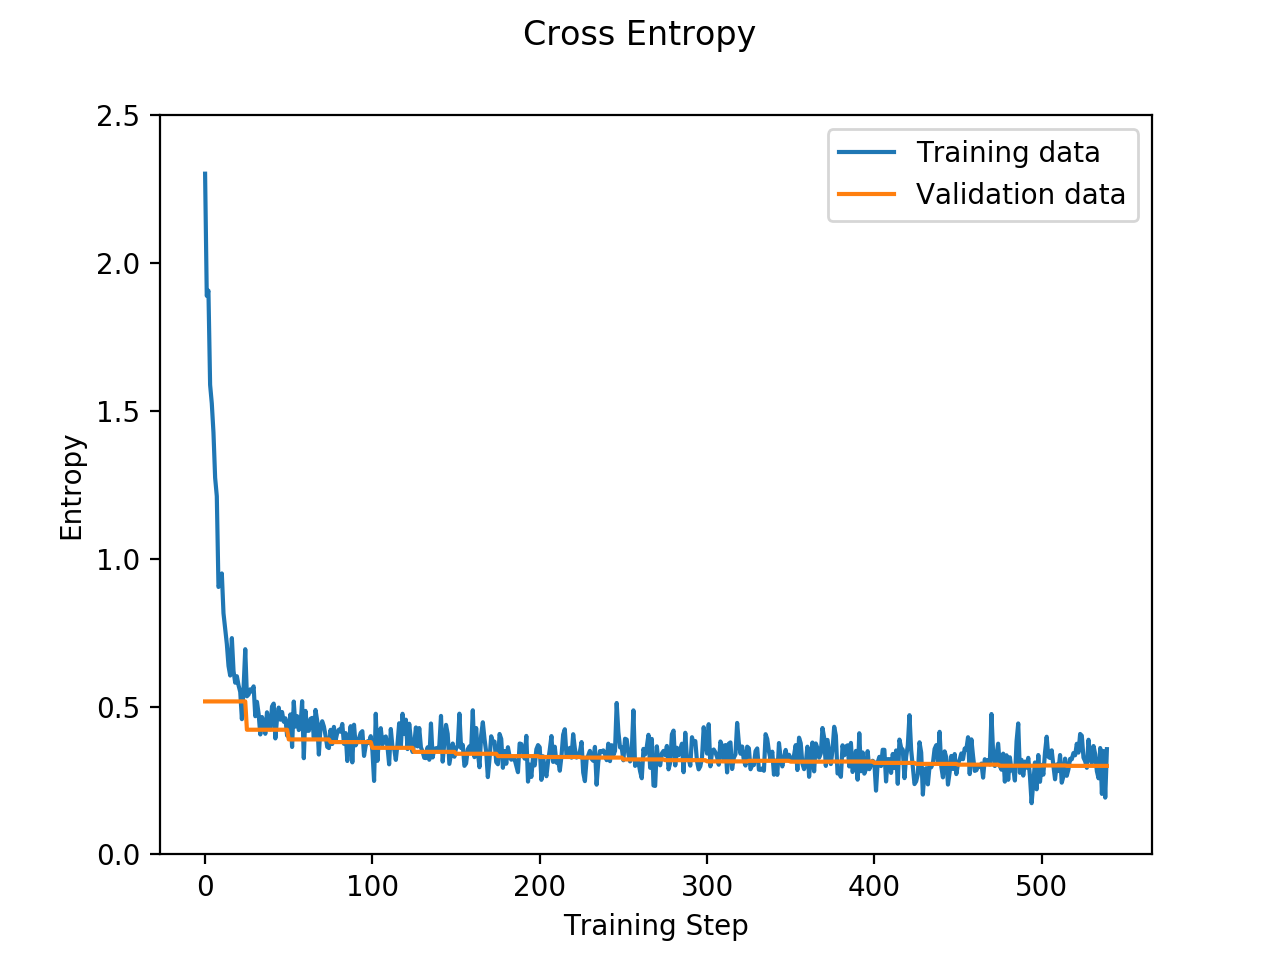

<IPython.core.display.Javascript object>


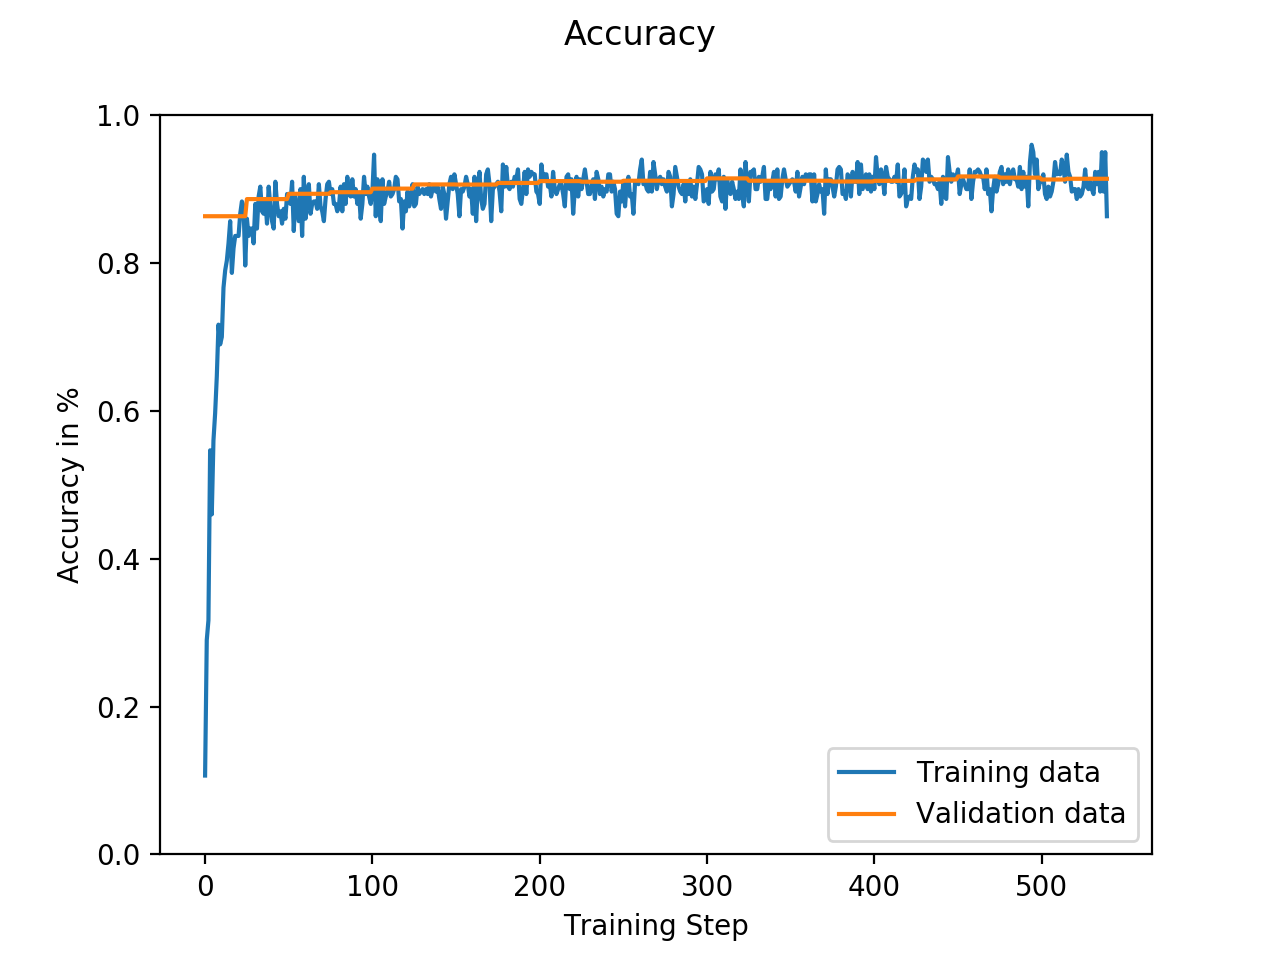

<IPython.core.display.Javascript object>


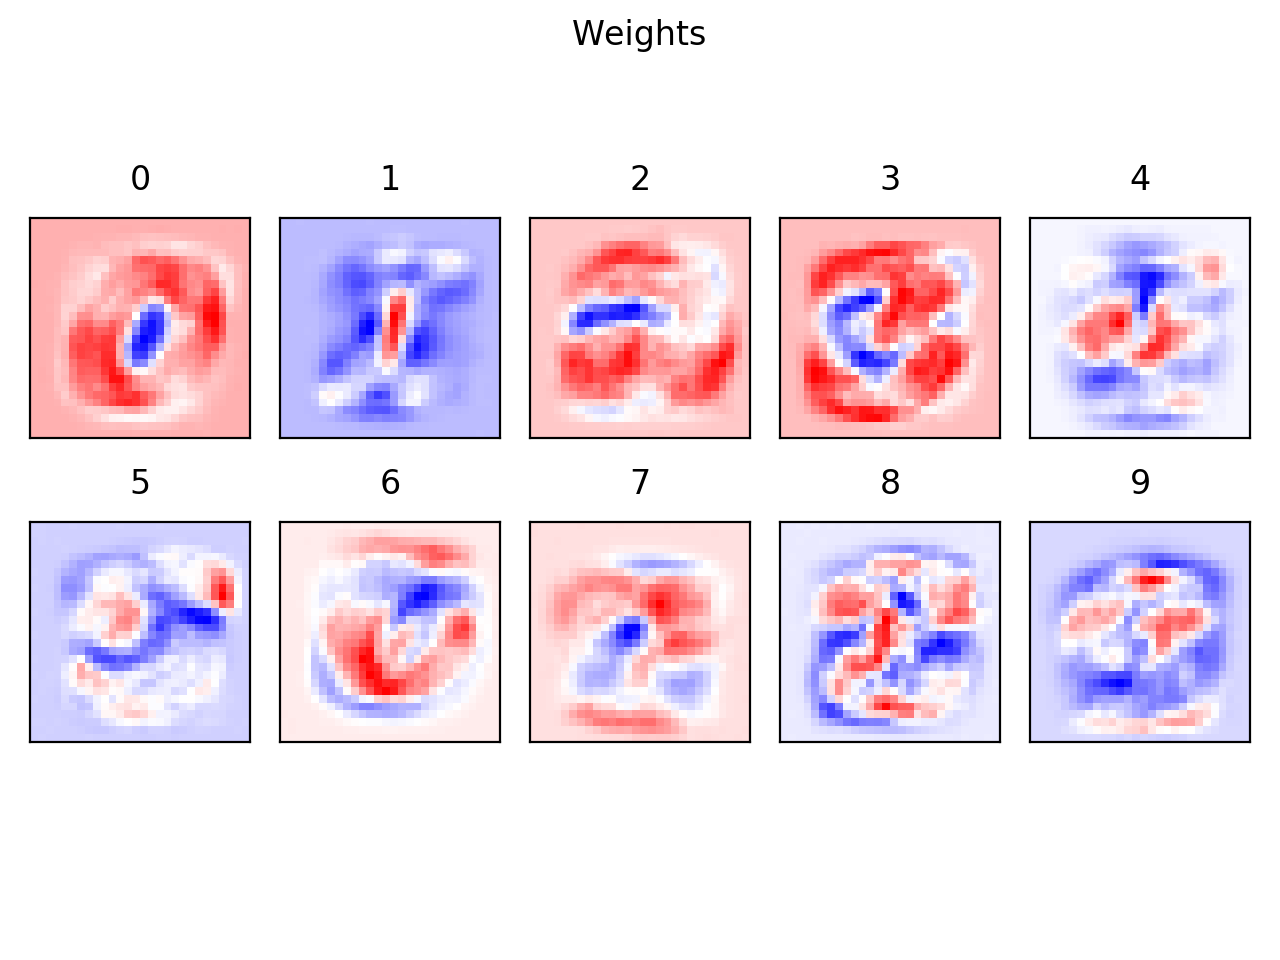

In [13]:
training_cross_entropies = np.zeros(training_steps * epochs)
validation_cross_entropies = np.zeros(training_steps * epochs)

training_accuracies = np.ones(training_steps * epochs)
validation_accuracies = np.ones(training_steps * epochs)

fig_cross_entropy, ax_cross_entropy = plt.subplots()
fig_cross_entropy.suptitle("Cross Entropy")

fig_accuracy, ax_accuracy = plt.subplots()
fig_accuracy.suptitle("Accuracy")

fig_weights, axs_weights = plt.subplots(2, 5)
fig_weights.suptitle("Weights")
fig_weights.set_tight_layout(True)

In the next part all important things happen. We create a new session, initialize all our variables (the weights and the biases) and then we train our network step by step.

In each step, we get a random mini-batch from the training data and vectorize the images. Then, we run a training step by feeding values into our network and evaluating nodes of the graph.

Every view steps, we evaluate our model with our validation data and update our plots, in order to keep track of the training process.

Once, we are done with training our network, we evaluate the performance of our network with the test data.

In [14]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    step = 0
    last_step = False
    for epoch in range(epochs):
        for images, labels in mnist.get_training_batch(mini_batch_size):
            images = images.reshape([-1, 784])
            training_cross_entropies[step], training_accuracies[step], _ = session.run(
                [cross_entropy, accuracy, training_step],
                feed_dict = {x: images, desired: labels}
            )
            
            if step == (training_steps * epochs)-1:
                last_step = True
            
            if step % plot_step_size == 0 or last_step:
                images, labels = next(mnist.get_validation_batch(0))
                images = images.reshape([-1, 784])
                
                validation_cross_entropy, validation_accuracy, _weights = session.run(
                    [cross_entropy, accuracy, weights],
                    feed_dict = {x: images, desired: labels}
                )
                
                if step != 0:
                    on = step - plot_step_size if not last_step else step - plot_step_size + 1
                    off = on + plot_step_size
                    validation_cross_entropies[on:off] = [validation_cross_entropy] * plot_step_size
                    validation_accuracies[on:off] = [validation_accuracy] * plot_step_size
                
                ax_cross_entropy.cla()
                ax_cross_entropy.plot(training_cross_entropies, label = "Training data")
                ax_cross_entropy.plot(validation_cross_entropies, label = "Validation data")
                ax_cross_entropy.set_xlabel("Training Step")
                ax_cross_entropy.set_ylabel("Entropy")
                ax_cross_entropy.set_ylim([0, 2.5])
                ax_cross_entropy.legend()
                fig_cross_entropy.canvas.draw()
                
                ax_accuracy.cla()
                ax_accuracy.plot(training_accuracies, label = "Training data")
                ax_accuracy.plot(validation_accuracies, label = "Validation data")
                ax_accuracy.set_xlabel("Training Step")
                ax_accuracy.set_ylabel("Accuracy in %")
                ax_accuracy.set_ylim([0, 1])
                ax_accuracy.legend(loc = "lower right")
                fig_accuracy.canvas.draw()
                
                for i, ax in enumerate(np.reshape(axs_weights, [-1])):
                    w = _weights[:, i].reshape(28, 28)
                    ax.cla()
                    ax.matshow(w, cmap = 'bwr')
                    ax.set_title(i)
                    ax.get_yaxis().set_visible(False)
                    ax.get_xaxis().set_visible(False)
                fig_weights.canvas.draw()
                
            step += 1
    
    test_accuracy = 0
    for step, (images, labels) in enumerate(mnist.get_test_batch(mini_batch_size)):
        images = images.reshape((-1, 784))
        test_accuracy += session.run(
            accuracy,
            feed_dict = {x: images, desired: labels}
        )
        
    print("Test Accuracy: " + str(test_accuracy / step))

Test Accuracy: 0.9450000058859587


This solution is brought to you by Lukas Braun. If you have any questions or comments, please do not hesitate to contact lbraun@uos.de